In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import seaborn as sns
import statsmodels.api as sm

from scipy.io import loadmat

In [2]:
# Read the Excel file
file_name = 'Data_4_Import_REST.xlsx'
excel_sheet_name = 'Depression Rest'
file_path = os.path.join("Depression_Study", "depression_data", file_name)
df_raw = pd.read_excel(file_path, sheet_name=excel_sheet_name)

# Extract values from the first column into two arrays
healthy_sample = df_raw[df_raw.iloc[:, 1] == 99].iloc[:, 0].tolist()
depressed_sample = df_raw[df_raw.iloc[:, 1] != 99].iloc[:, 0].tolist()

# Extract AAL source names
cser_values = loadmat("cser_values.mat")
source_names = [(cser_values['source_names'][i][0][0]) for i in range(60)]

In [3]:
# Load EEG source data from -v7.3 .mat file
eeg_source = h5py.File('eeg_source.mat', 'r')

eeg_source_open = eeg_source['eeg_source_open']
eeg_source_closed = eeg_source['eeg_source_closed']

def get_eeg_list(eeg_source, sample_list):
    eeg_keys = eeg_source.keys()
    return [eeg_source[f'x{sample}'] for sample in sample_list if f'x{sample}' in eeg_keys]

eeg_source_open_healthy = get_eeg_list(eeg_source_open, healthy_sample)
eeg_source_open_depressed = get_eeg_list(eeg_source_open, depressed_sample)
eeg_source_closed_healthy = get_eeg_list(eeg_source_closed, healthy_sample)
eeg_source_closed_depressed = get_eeg_list(eeg_source_closed, depressed_sample)

In [ ]:
# Prep separated from calculation because np calls slow down after importing LZ76

def lzc_prep(eeg_source):
    all_subjects = []

    for i, subj_data in enumerate(eeg_source):
        if i % 10 == 0:
            print(f"Processing {i+1}/{len(eeg_source)}")
        subj_data = np.array(subj_data)  # shape: (samples, sources, trials)
        subj_srcs = []

        for src in range(60):
            # Reshape: concatenate across trials for the current source
            data_1d = subj_data[:, src, :].reshape(-1)

            # Standardize (zero mean, unit variance)
            data_1d = (data_1d - np.mean(data_1d)) / np.std(data_1d)
            
            # Binarize by median thresholding
            threshold = np.median(data_1d)
            binary_seq = (data_1d > threshold).astype(int)

            # Split into 4s epochs (sr = 500Hz)
            segment_length = 4 * 500
            n_segments = len(binary_seq) // segment_length
            subj_segments = [binary_seq[i*segment_length:(i+1)*segment_length] for i in range(n_segments)]

            subj_srcs.append(subj_segments)

        all_subjects.append(subj_srcs)

    print()
    return all_subjects


prep_open_healthy = lzc_prep(eeg_source_open_healthy)
prep_open_depressed = lzc_prep(eeg_source_open_depressed)   
prep_closed_healthy = lzc_prep(eeg_source_closed_healthy)   
prep_closed_depressed = lzc_prep(eeg_source_closed_depressed)   

Processing 1/89
Processing 11/89
Processing 21/89
Processing 31/89
Processing 41/89
Processing 51/89
Processing 61/89
Processing 71/89
Processing 81/89

Processing 1/30
Processing 11/30
Processing 21/30

Processing 1/89
Processing 11/89
Processing 21/89
Processing 31/89
Processing 41/89
Processing 51/89
Processing 61/89
Processing 71/89
Processing 81/89

Processing 1/30
Processing 11/30
Processing 21/30



In [6]:
# Took 588 minutes = 9.8 hours

from lz76.lz76 import LZ76


# def calc_er(X):
#     lz = LZ76(X) # Compute Lempel-Ziv complexity
#     er = lz*np.log2(len(X))/len(X) # Normalize using log2(length)
#     return er


def compute_lz76_er(prep_data):
    """
    Computes LZ76 complexity for each segment in prep_data.
    Returns:
        lz76_per_subject_source: list of lists (subject, source mean)
        lz76_per_subject: list (subject mean)
        lz76_overall: float (overall mean)
    """
    lz76_per_subject_source = []
    lz76_per_subject = []

    er_per_subject_source = []
    er_per_subject = []

    for i, subj in enumerate(prep_data):
        subj_sources_lz = []
        subj_sources_er = []

        for j, src in enumerate(subj):
            if j % 10 == 0:
                print(f"Processing {i+1}/{len(prep_data)} subject's {j+1}/{len(subj)} source")
            
            # Calculating LZC and ER per subject/source/segment
            src_seg_lz = [LZ76(seg) for seg in src if len(seg) > 0]
            src_seg_er = [lz * np.log2(len(seg)) / len(seg) for lz, seg in zip(src_seg_lz, src) if len(seg) > 0]
            
            # if j % 10 == 0:
            #     print(f"Subject {i+1}, Source {j+1}: LZC = {np.nanmean(src_seg_lz):.4f}, ER = {np.nanmean(src_seg_er):.4f}")

            # Calculating LZC and ER per subject/source
            subj_sources_lz.append(np.nanmean(src_seg_lz))
            subj_sources_er.append(np.nanmean(src_seg_er))
        
        lz76_per_subject_source.append(subj_sources_lz)
        er_per_subject_source.append(subj_sources_er)

        # Calculating LZC and ER per subject
        lz76_per_subject.append(np.nanmean(subj_sources_lz))
        er_per_subject.append(np.nanmean(subj_sources_er))

    # Calculating LZC and ER overall
    lz76_overall = np.nanmean(lz76_per_subject)
    er_overall = np.nanmean(er_per_subject)
    
    print()

    lz76 = {
        'per_subject_source': lz76_per_subject_source,
        'per_subject': lz76_per_subject,
        'overall': lz76_overall
    }

    er = {
        'per_subject_source': er_per_subject_source,
        'per_subject': er_per_subject,
        'overall': er_overall
    }

    return lz76, er


(lz76_open_healthy, er_open_healthy) = compute_lz76_er(prep_open_healthy)
(lz76_open_depressed, er_open_depressed) = compute_lz76_er(prep_open_depressed)
(lz76_closed_healthy, er_closed_healthy) = compute_lz76_er(prep_closed_healthy)
(lz76_closed_depressed, er_closed_depressed) = compute_lz76_er(prep_closed_depressed)

Processing 1/89 subject's 1/60 source
Processing 1/89 subject's 11/60 source
Processing 1/89 subject's 21/60 source
Processing 1/89 subject's 31/60 source
Processing 1/89 subject's 41/60 source
Processing 1/89 subject's 51/60 source
Processing 2/89 subject's 1/60 source
Processing 2/89 subject's 11/60 source
Processing 2/89 subject's 21/60 source
Processing 2/89 subject's 31/60 source
Processing 2/89 subject's 41/60 source
Processing 2/89 subject's 51/60 source
Processing 3/89 subject's 1/60 source
Processing 3/89 subject's 11/60 source
Processing 3/89 subject's 21/60 source
Processing 3/89 subject's 31/60 source
Processing 3/89 subject's 41/60 source
Processing 3/89 subject's 51/60 source
Processing 4/89 subject's 1/60 source
Processing 4/89 subject's 11/60 source
Processing 4/89 subject's 21/60 source
Processing 4/89 subject's 31/60 source
Processing 4/89 subject's 41/60 source
Processing 4/89 subject's 51/60 source
Processing 5/89 subject's 1/60 source
Processing 5/89 subject's 11/6

KeyboardInterrupt: 

In [ ]:
# Save the results to a file for later retrieval
lz76_values = {
    'lz76_open_healthy': lz76_open_healthy,
    'lz76_open_depressed': lz76_open_depressed,
    'lz76_closed_healthy': lz76_closed_healthy,
    'lz76_closed_depressed': lz76_closed_depressed
}

with open('lz76_values.pkl', 'wb') as f:
    pickle.dump(lz76_values, f)

er_values = {
    'er_open_healthy': er_open_healthy,
    'er_open_depressed': er_open_depressed,
    'er_closed_healthy': er_closed_healthy,
    'er_closed_depressed': er_closed_depressed
}

with open('er_values.pkl', 'wb') as f:
    pickle.dump(er_values, f)

In [5]:
# Load the results from the file
lz76_values = None
with open('lz76_values.pkl', 'rb') as f:
    lz76_values = pickle.load(f)

# Unpack the results
lz76_open_healthy = lz76_values['lz76_open_healthy']
lz76_open_depressed = lz76_values['lz76_open_depressed']
lz76_closed_healthy = lz76_values['lz76_closed_healthy']
lz76_closed_depressed = lz76_values['lz76_closed_depressed']

In [ ]:
region_map = {
    'frontal': [f'src{i+1:02d}_{source_names[i]}' for i in range(2, 16)] + [f'src{i:02d}_{source_names[i]}' for i in range(18, 24)],
    'occipital': [f'src{i+1:02d}_{source_names[i]}' for i in range(24, 36)],
    'parietal': [f'src{i+1:02d}_{source_names[i]}' for i in range(38, 50)],
    'sensorimotor': [f'src{i+1:02d}_{source_names[i]}' for i in [0, 1, 16, 17, 36, 37]],
    'temporal': [f'src{i+1:02d}_{source_names[i]}' for i in range(50, 60)]
}


# Average LZC for each source across subjects for each condition
def average_lz76_per_source(lz76_tuple):
    # lz76_tuple[0] is a list of lists: [subject][source]
    lz76_per_subject_source = lz76_tuple[0]
    # Transpose to [source][subject]
    lz76_per_source = np.array(lz76_per_subject_source).T
    # Average across subjects for each source
    return np.nanmean(lz76_per_source, axis=1)


def structure_lzc(lzc_calcs, eyes, health):

    subj_ids = healthy_sample if health == 'healthy' else depressed_sample

    lzc_subdictionary = []
    lzc_calcs_source = average_lz76_per_source(lzc_calcs)

    # average per eyes/health condition
    lzc_subdictionary.append({
        'id': 'average',
        'eyes': eyes,
        'depressed': 1 if health == 'depressed' else 0,
        'area': 'brain',
        'lz76': lzc_calcs[2]
    })

    # average per eyes/health condition per subject
    for subj_idx, val in enumerate(lzc_calcs[1]):
        lzc_subdictionary.append({
            'id': subj_ids[subj_idx],
            'eyes': eyes,
            'depressed': 1 if health == 'depressed' else 0,
            'area': 'brain',
            'lz76': val
        })
    
    # average per eyes/health condition per source
    for src_idx, val in enumerate(lzc_calcs_source):
        lzc_subdictionary.append({
            'id': 'average',
            'eyes': eyes,
            'depressed': 1 if health == 'depressed' else 0,
            'area': f'src{src_idx+1:02d}_{source_names[src_idx]}',
            'lz76': val
        })
    
    # average per eyes/health condition per subject/source
    for subj_idx, subj_val in enumerate(lzc_calcs[0]):
        for src_idx, val in enumerate(subj_val):
            lzc_subdictionary.append({
                'id': subj_ids[subj_idx],
                'eyes': eyes,
                'depressed': 1 if health == 'depressed' else 0,
                'area': f'src{src_idx+1:02d}_{source_names[src_idx]}',
                'lz76': val
            })
    
    # average per eyes/health condition per subject/region
    for subj_idx, subj_val in enumerate(lzc_calcs[0]):
        for region, srcs in region_map.items():
            region_lz76 = np.nanmean([subj_val[int(src.split('_')[0][3:])-1] for src in srcs if int(src.split('_')[0][3:])-1 < len(subj_val)])
            lzc_subdictionary.append({
                'id': subj_ids[subj_idx],
                'eyes': eyes,
                'depressed': 1 if health == 'depressed' else 0,
                'area': region,
                'lz76': region_lz76
            })
    
    # average per eyes/health condition per region
    for region, srcs in region_map.items():
        region_lz76 = np.nanmean([lzc_calcs_source[int(src.split('_')[0][3:])-1] for src in srcs if int(src.split('_')[0][3:])-1 < len(lzc_calcs_source)])
        lzc_subdictionary.append({
            'id': 'average',
            'eyes': eyes,
            'depressed': 1 if health == 'depressed' else 0,
            'area': region,
            'lz76': region_lz76
        })
    
    return lzc_subdictionary


lzc_dictionary = []

lzc_dictionary.extend(structure_lzc(lz76_open_healthy, 'open', 'healthy'))
lzc_dictionary.extend(structure_lzc(lz76_open_depressed, 'open', 'depressed'))
lzc_dictionary.extend(structure_lzc(lz76_closed_healthy, 'closed', 'healthy'))
lzc_dictionary.extend(structure_lzc(lz76_closed_depressed, 'closed', 'depressed'))

lzc_df = pd.DataFrame(lzc_dictionary)

df = pd.merge(lzc_df, df_raw, on='id', how='left')

# print(lzc_df)
# print(df_raw)
# print(df)

NameError: name 'X' is not defined

In [67]:
# Drop CUSTOM outliers from the DataFrame if they exist
outlier_ids = ['527','535']
# 527 > closed epochs (channels 2, 40, 54) behaves like a random walk according to MVGC
# 535 > open epochs are too noisy
ids_in_df = df['id'].astype(str).isin(outlier_ids)
if ids_in_df.any():
    df = df[~ids_in_df]
print("\nDropped outliers with IDs:", outlier_ids)


Dropped outliers with IDs: ['527', '535']


In [68]:
df['depressed'] = df['MDD'].apply(lambda x: 1 if x == 1 else 0)
df['intercept'] = 1
df['age_squared'] = df['age'] ** 2
if df['sex'].max() == 2:
    df['sex'] = df['sex'] - 1

# Perform regression analysis for each combination of eyes, area, and band
variables = ['intercept', 'depressed', 'BDI', 'BDI_Anh', 'BDI_Mel', 'TAI', 'sex', 'age', 'age_squared']
rlm_results = pd.DataFrame(columns=['eyes', 'area', 'variable', 'p_value', 't_value', 'p_significant', 't_significant'])

for eyes in ['open', 'closed']:
    for area in df['area'].unique():
        # Run sm.RLM for each subset of the DataFrame
        subset = df[(df['eyes'] == eyes) & (df['area'] == area)]
        if subset.empty:
            continue
        model = sm.RLM(subset['lz76'], subset[variables], missing='drop', M=sm.robust.norms.HuberT())
        results = model.fit()
        # print(results.summary())
        for var in variables[1:]:
            p_significant = results.pvalues[var] <= 0.05
            t_significant = abs(results.tvalues[var]) >= 1.7
            new_permutation = pd.DataFrame([{
                'eyes': eyes,
                'area': area,
                'variable': var,
                'p_value': results.pvalues[var],
                't_value': results.tvalues[var],
                'p_significant': p_significant,
                't_significant': t_significant
            }])
            rlm_results = pd.concat([rlm_results, new_permutation], ignore_index=True)

# print(rlm_results)

C:\Users\lukad\AppData\Local\Temp\ipykernel_29592\1133357772.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  rlm_results = pd.concat([rlm_results, new_permutation], ignore_index=True)


## PLOTS

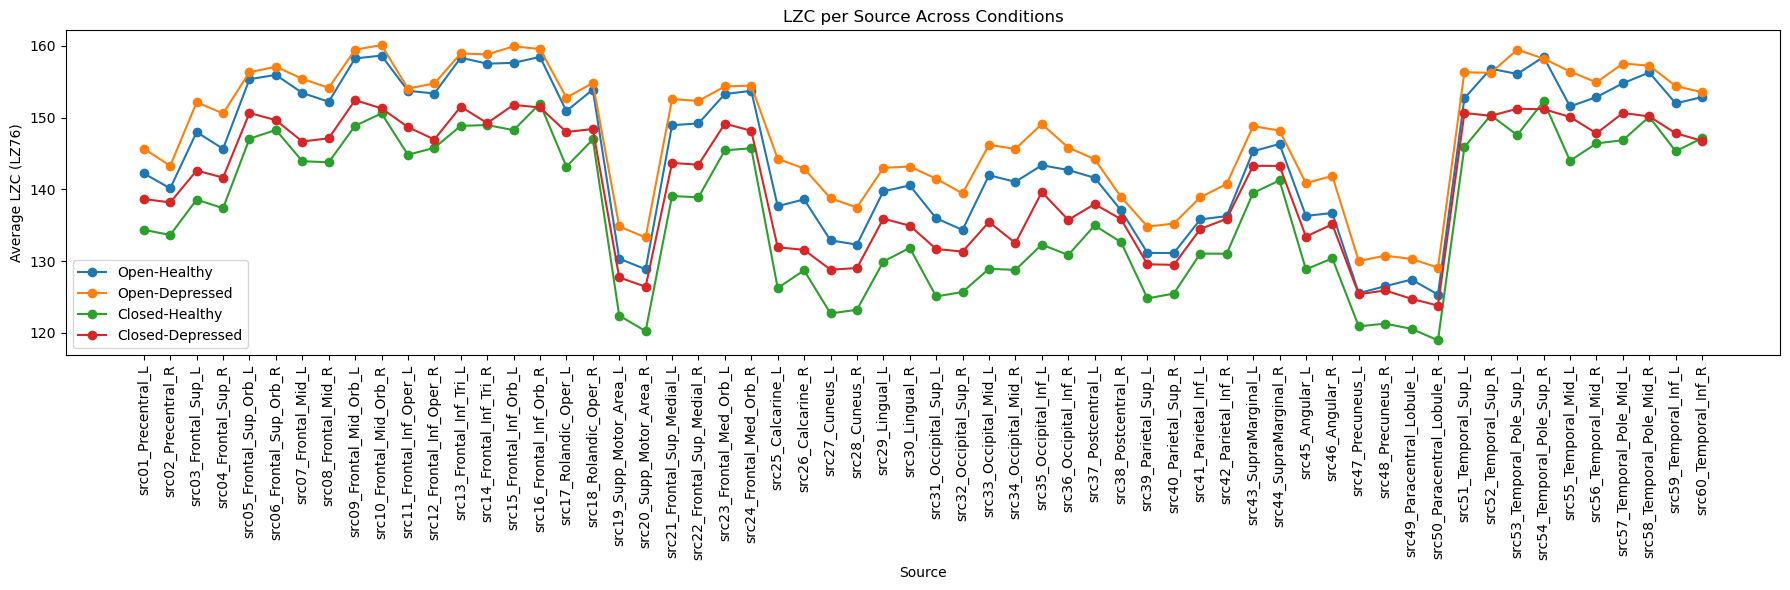

In [70]:
source_indices = np.arange(1, 61)
plt.figure(figsize=(18, 6))

for eyes in lzc_df['eyes'].unique():
    for depressed in lzc_df['depressed'].unique():
        mask = (
            (lzc_df['eyes'] == eyes) &
            (lzc_df['depressed'] == depressed) &
            (lzc_df['id'] == 'average') &
            (lzc_df['area'].str.startswith('src'))
        )
        vals = lzc_df.loc[mask, 'lz76'].values
        label = f'{eyes.capitalize()}-{"Depressed" if depressed == 1 else "Healthy"}'
        plt.plot(source_indices, vals, marker='o', label=label)

plt.xticks(source_indices, [f'src{idx+1:02d}_{source_names[idx]}' for idx in range(60)], rotation=90)
plt.xlabel('Source')
plt.ylabel('Average LZC (LZ76)')
plt.title('LZC per Source Across Conditions')
plt.legend()
plt.tight_layout()
plt.show()

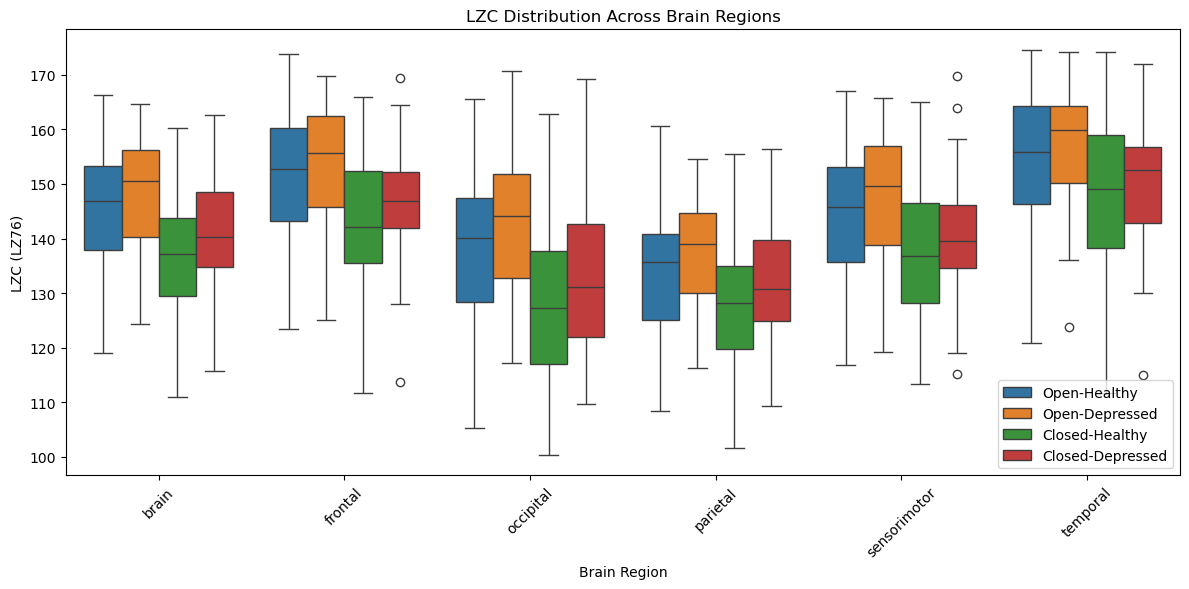

In [71]:
# Plotting CSER distribution across brain regions
mask = (lzc_df['id'] != 'average') & (~lzc_df['area'].str.startswith('src'))
df_subset = lzc_df.loc[mask, ['area', 'lz76', 'eyes', 'depressed']].copy()
df_subset['eyes'] = df_subset['eyes'].str.capitalize()
df_subset['depressed'] = df_subset['depressed'].map({0: 'Healthy', 1: 'Depressed'})
df_subset['condition'] = df_subset['eyes'] + '-' + df_subset['depressed']

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_subset, x='area', y='lz76', hue='condition')

plt.xlabel('Brain Region')
plt.ylabel('LZC (LZ76)')
plt.title('LZC Distribution Across Brain Regions')
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

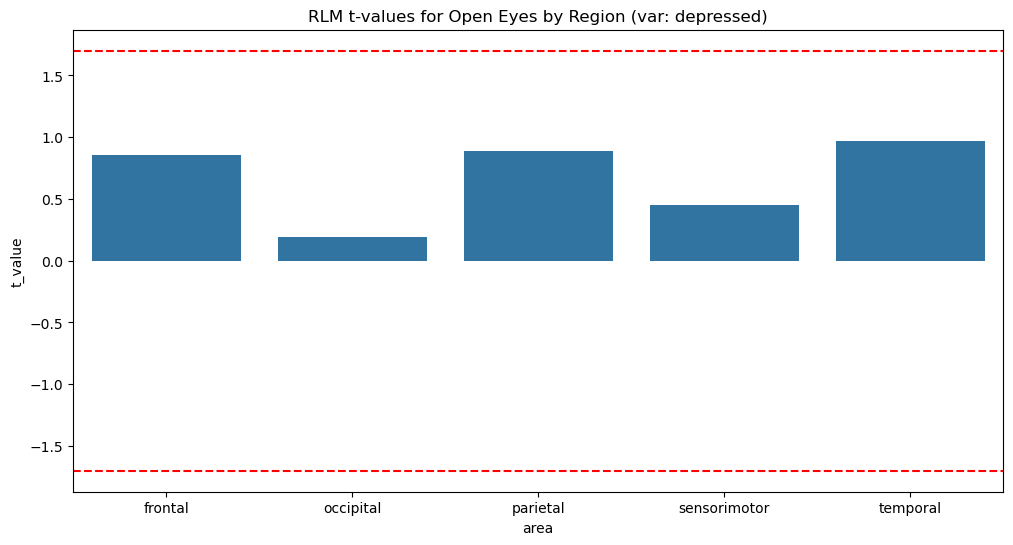

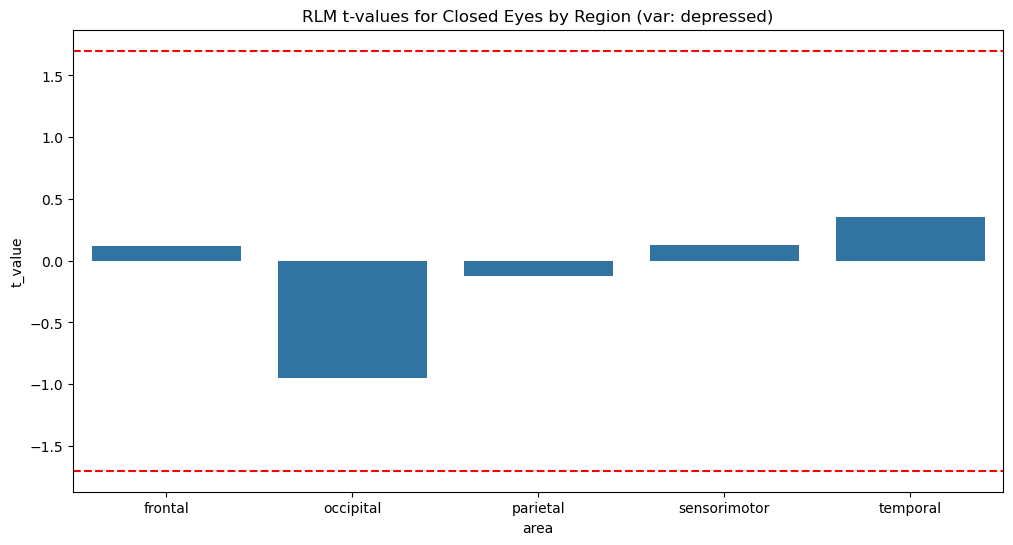

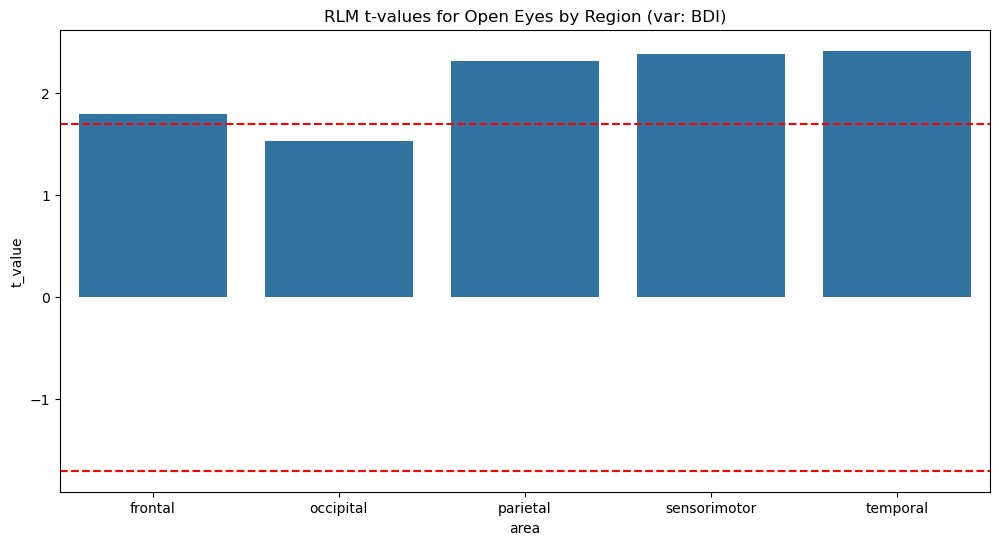

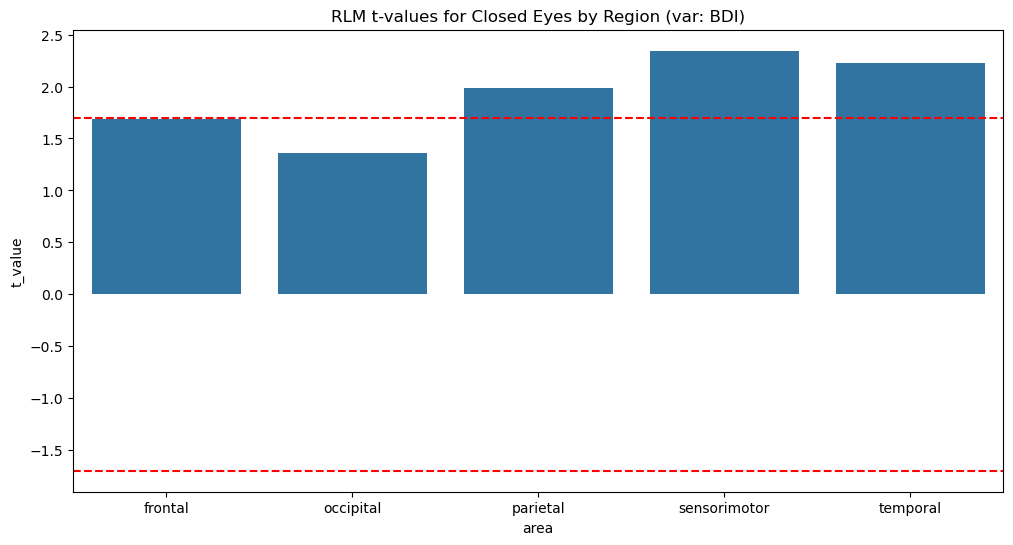

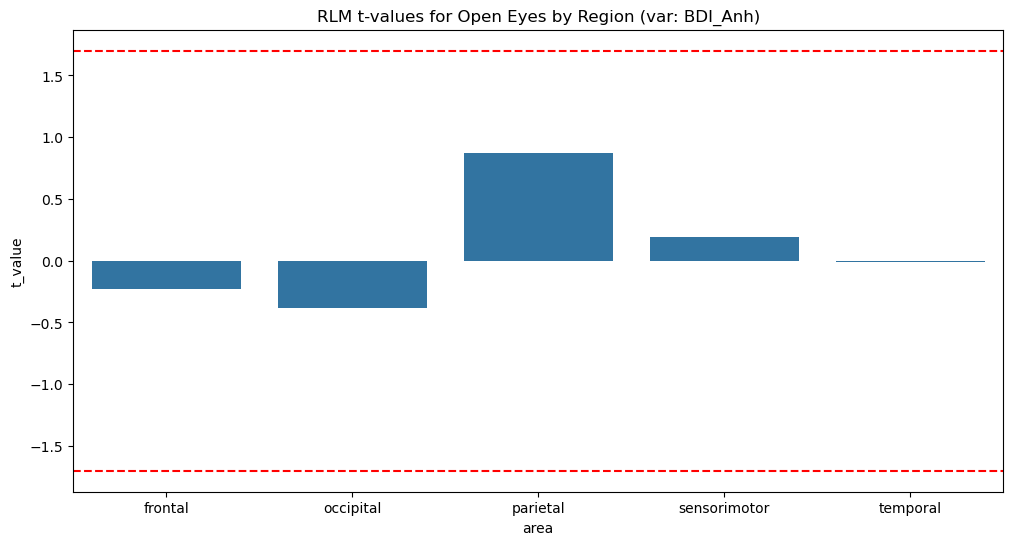

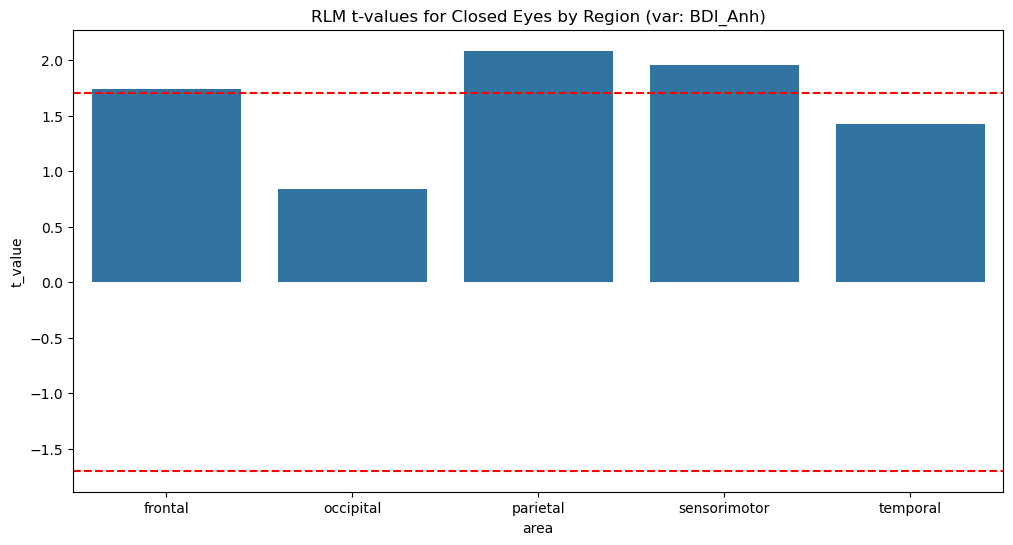

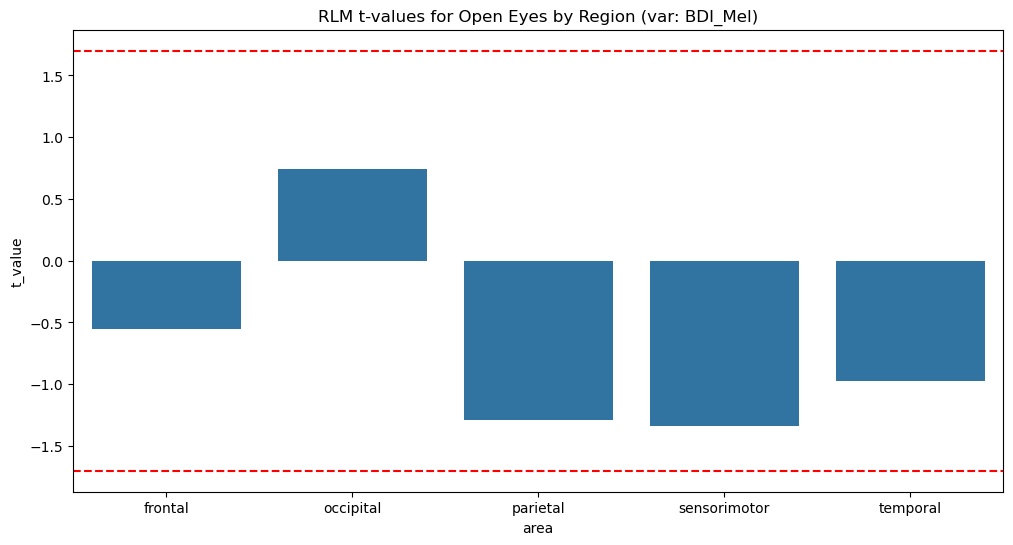

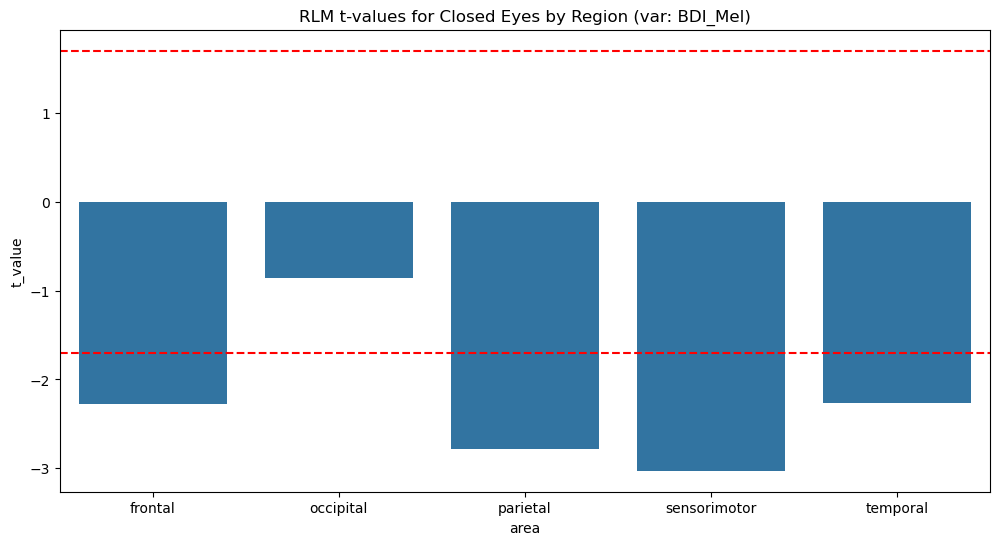

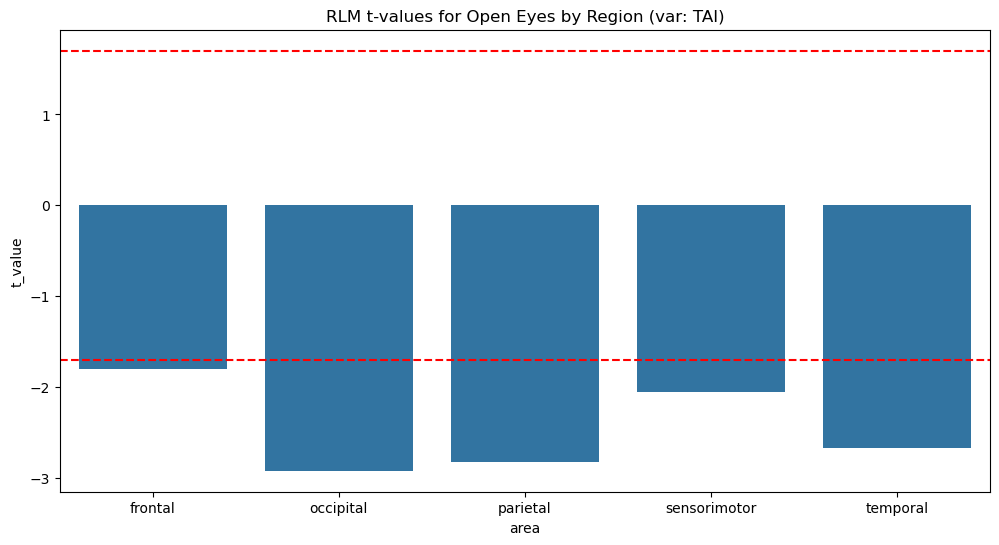

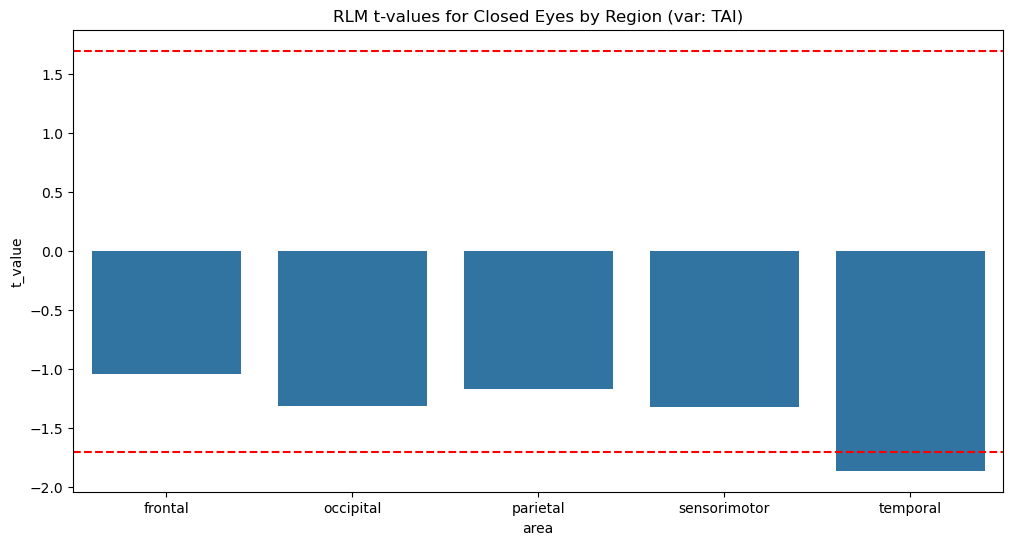

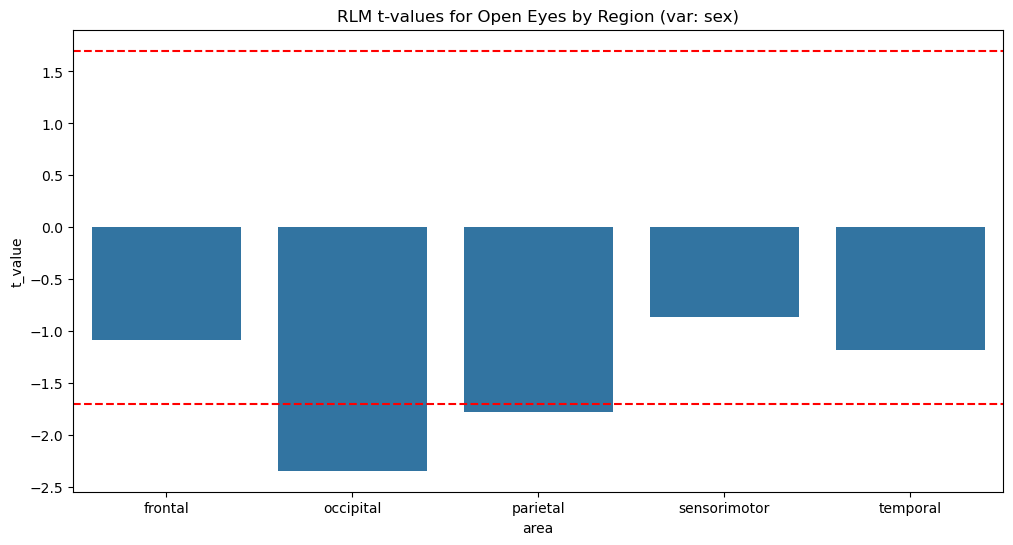

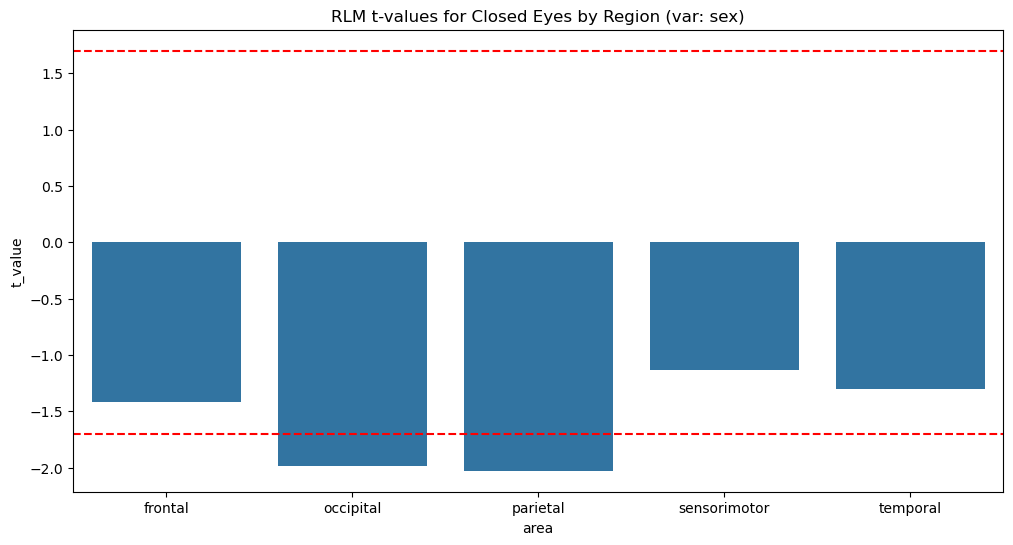

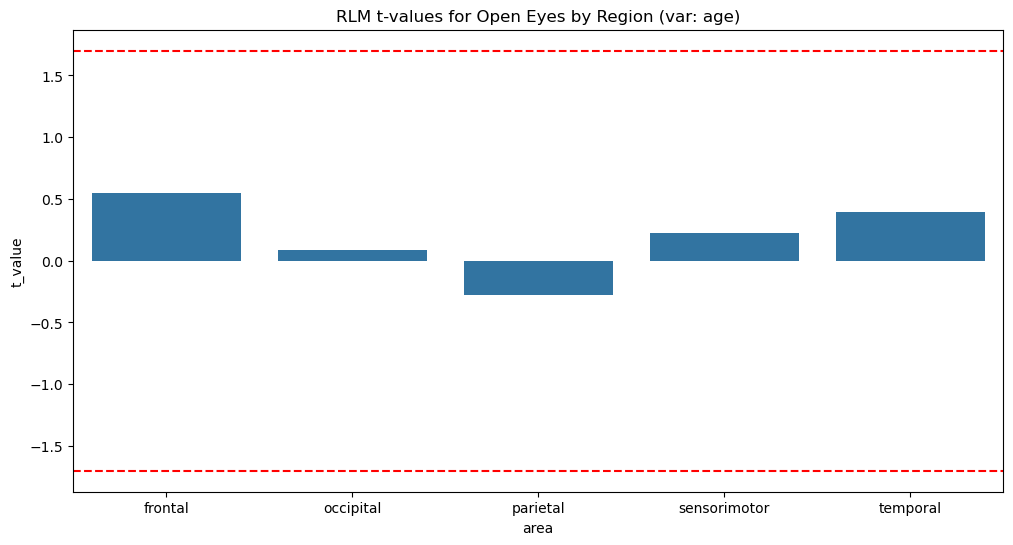

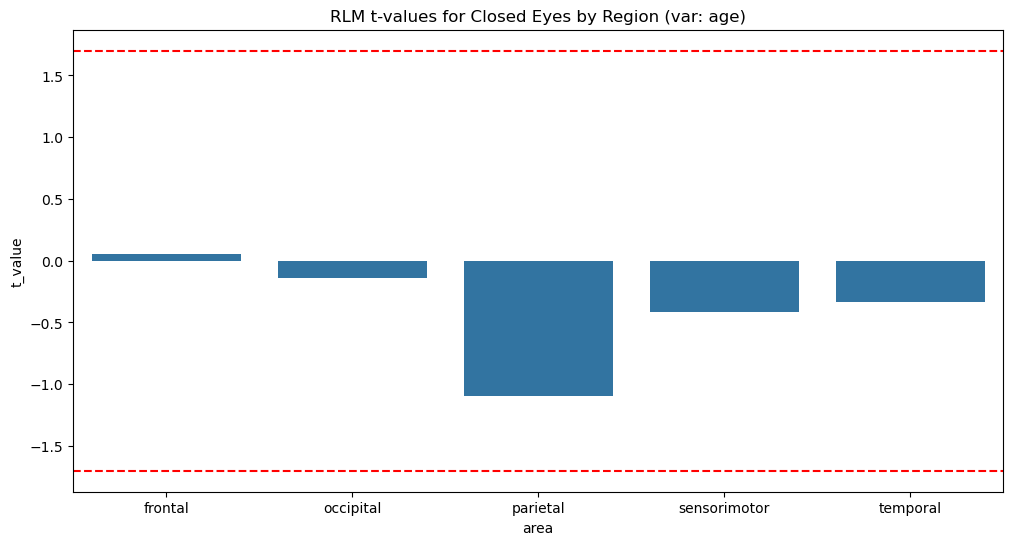

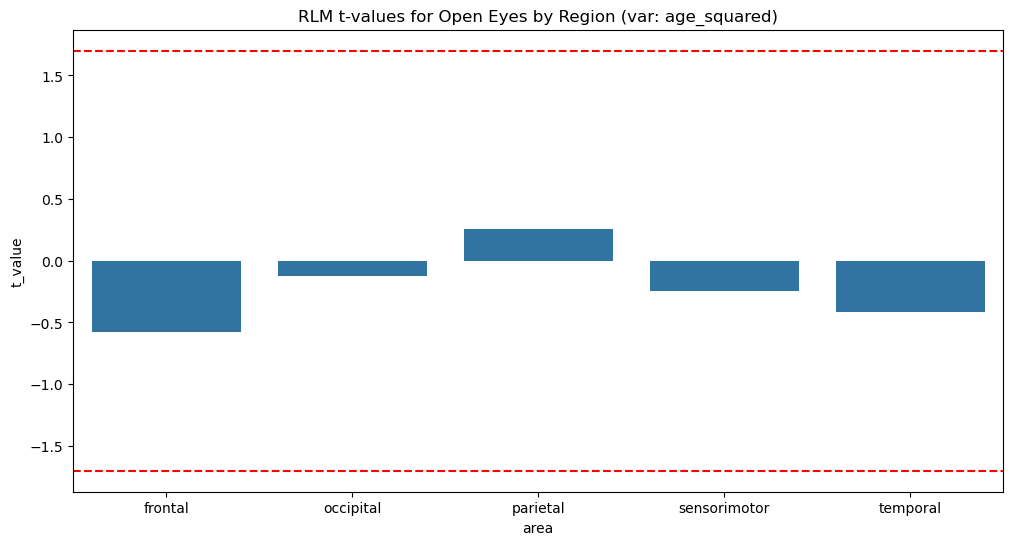

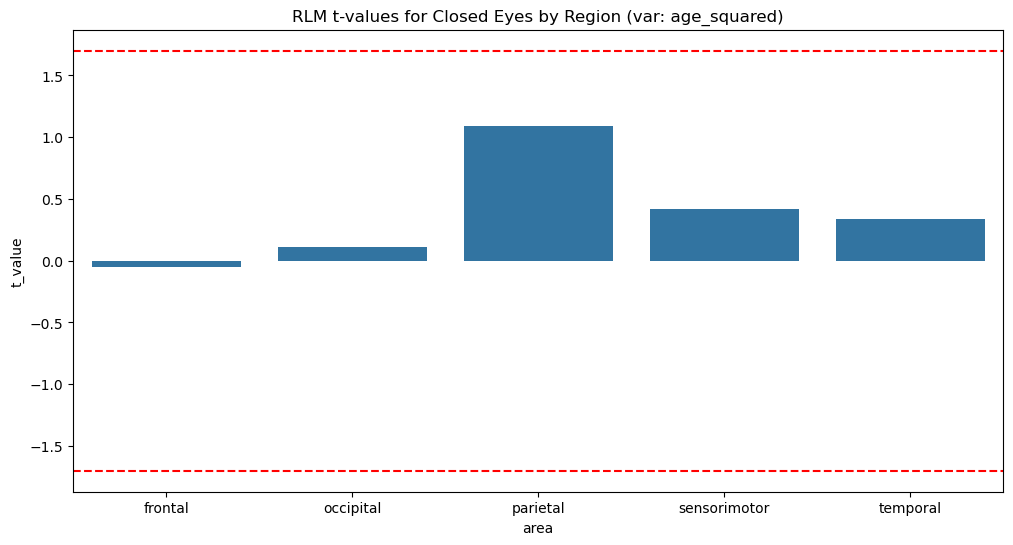

In [72]:
def barplot_significance(eyes, var):
    plt.figure(figsize=(12, 6))
    sns.barplot(data=rlm_results[(rlm_results['eyes'] == eyes) & (rlm_results['variable'] == var) & (rlm_results['area'].isin(region_map.keys()))],
                x='area', y='t_value', errorbar=None)
    plt.title(f'RLM t-values for {str.capitalize(eyes)} Eyes by Region (var: {var})')
    plt.axhline(y=1.7, color='r', linestyle='--')
    plt.axhline(y=-1.7, color='r', linestyle='--')
    plt.show()

for var in variables:
    if var in ['intercept']:
        continue
    barplot_significance('open', var)
    barplot_significance('closed', var)

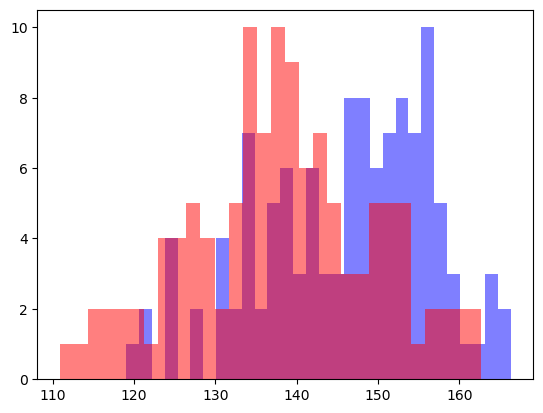

In [73]:
# Plot the distribution of LZ76 values with eyes set to 'open' and 'closed'
mask_open = (df['eyes'] == 'open') & (df['area'] == 'brain')
mask_closed = (df['eyes'] == 'closed') & (df['area'] == 'brain')

plt.hist(df[mask_open]['lz76'].dropna(), bins=30, alpha=0.5, color='blue', label='LZ76 Open');
plt.hist(df[mask_closed]['lz76'].dropna(), bins=30, alpha=0.5, color='red', label='LZ76 Closed');